# Deep Learning Final Project

Aryaman Shodhan ashodha1,
Trisha Karani \<JHED\>,
Shreya Wadhwa \<JHED\>,
Aidan Aug \<JHED\>



In [48]:
## Mount Google Drive Data
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [49]:
## Standard Library
import os
import json
import re

## External Libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as functional
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from skimage import io
from torchvision import transforms, models
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [50]:
use_gpu = torch.cuda.is_available()

# Data Preprocessing

TODO: INCLUDE THE STEPS PERFORMED FOR PREPROCESSING THE DATA

Eg. Augmentations, split into train val test, etc.

In [51]:
data_dir = "/content/gdrive/MyDrive/Deep_Learning/archive"

data = []
for root, _, files in os.walk(data_dir):
  files = sorted(filter(lambda x: re.search("endo.png$", x) is not None, files))
  for idx in range(len(files)):
    data.append(os.path.join(root, files[idx]))

random.shuffle(data)

In [52]:
class ImageDataset(Dataset):
  def __init__(self, data, transforms=None):
    self.data = data
    self.transforms = transforms
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    img = io.imread(self.data[idx])
    if self.transforms:
      img = self.img_transform(img)
    return img

  def img_transform(self, img):
    img = self.transforms(img)
    return img

In [53]:
batch_size = 32
image_size = 256

img_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize(size=(300, 525)),
  transforms.CenterCrop(size=image_size)
])

dataset = ImageDataset(data=data, transforms=img_transforms)

mask = random.sample(range(dataset.__len__()), 6400)

dataloader = DataLoader(dataset=dataset, batch_size=batch_size, sampler=SubsetRandomSampler(mask))

print(len(dataloader))

200


In [54]:
def visualize_real_images(dataloader, batch_size):
  real_img_list = next(iter(dataloader))

  plt.figure(figsize=(20,20))
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Real Images")
  plt.imshow(np.transpose(torchvision.utils.make_grid(real_img_list[:batch_size], padding=5), (1, 2, 0)))

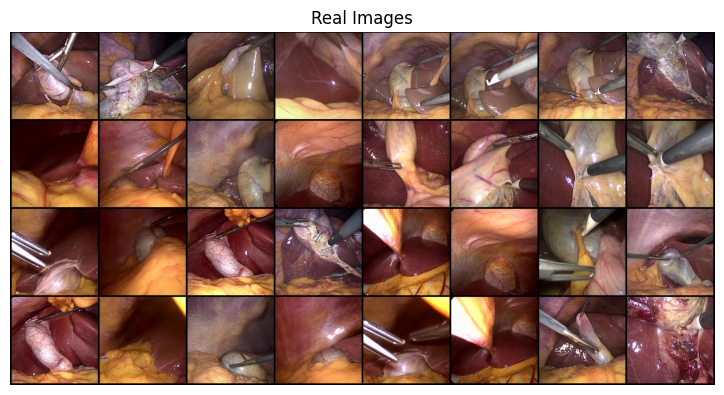

In [55]:
visualize_real_images(dataloader, batch_size)

## Model Setup

In [56]:
# Size of the latent space
z_size = 100

# Common factor for number of channels in each layer of the Generator
g_size = 32

# Common factor for number of channels in each layer of the Discriminator
d_size = 32

# Number of channels in the generated images
n_channels = 3

### Generator

In [57]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()

    self.deconv1 = nn.ConvTranspose2d(z_size, g_size * 32, kernel_size=4, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(g_size * 32)

    self.deconv2 = nn.ConvTranspose2d(g_size * 32, g_size * 16, kernel_size=4, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(g_size * 16)

    self.deconv3 = nn.ConvTranspose2d(g_size * 16, g_size * 8, kernel_size=4, stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(g_size * 8)

    self.deconv4 = nn.ConvTranspose2d(g_size * 8, g_size * 4, kernel_size=4, stride=2, padding=1)
    self.bn4 = nn.BatchNorm2d(g_size * 4)

    self.deconv5 = nn.ConvTranspose2d(g_size * 4, g_size * 2, kernel_size=4, stride=2, padding=1)
    self.bn5 = nn.BatchNorm2d(g_size * 2)

    self.deconv6 = nn.ConvTranspose2d(g_size * 2, g_size, kernel_size=4, stride=2, padding=1)
    self.bn6 = nn.BatchNorm2d(g_size)

    self.deconv_out = nn.ConvTranspose2d(g_size, n_channels, kernel_size=4, stride=2, padding=1)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    x = self.bn1(self.deconv1(x))
    x = self.relu(x)
    
    x = self.bn2(self.deconv2(x))
    x = self.relu(x)
    
    x = self.bn3(self.deconv3(x))
    x = self.relu(x)
    
    x = self.bn4(self.deconv4(x))
    x = self.relu(x)
    
    x = self.bn5(self.deconv5(x))
    x = self.relu(x)
    
    x = self.bn6(self.deconv6(x))
    x = self.relu(x)
    
    x = self.deconv_out(x)
    x = self.sigmoid(x)
    
    return x

### Discriminator

In [58]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.conv1 = nn.Conv2d(n_channels, d_size, kernel_size=4, stride=2, padding=1)

    self.conv2 = nn.Conv2d(d_size, d_size * 2, kernel_size=4, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(d_size * 2)

    self.conv3 = nn.Conv2d(d_size * 2, d_size * 4, kernel_size=4, stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(d_size * 4)

    self.conv4 = nn.Conv2d(d_size * 4, d_size * 8, kernel_size=4, stride=2, padding=1)
    self.bn4 = nn.BatchNorm2d(d_size * 8)

    self.conv5 = nn.Conv2d(d_size * 8, d_size * 16, kernel_size=4, stride=2, padding=1)
    self.bn5 = nn.BatchNorm2d(d_size * 16)

    self.conv6 = nn.Conv2d(d_size * 16, d_size * 32, kernel_size=4, stride=2, padding=1)
    self.bn6 = nn.BatchNorm2d(d_size * 32)

    self.conv_out = nn.Conv2d(d_size * 32, 1, kernel_size=4, stride=1, padding=0)
    
    self.dropout = nn.Dropout(p=0.3)

    self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.leaky_relu(x)

    x = self.dropout(self.bn2(self.conv2(x)))
    x = self.leaky_relu(x)

    x = self.dropout(self.bn3(self.conv3(x)))
    x = self.leaky_relu(x)

    x = self.dropout(self.bn4(self.conv4(x)))
    x = self.leaky_relu(x)

    x = self.dropout(self.bn5(self.conv5(x)))
    x = self.leaky_relu(x)

    x = self.dropout(self.bn6(self.conv6(x)))
    x = self.leaky_relu(x)

    x = self.conv_out(x)
    x = self.sigmoid(x)

    return x

## Training Loop

In [59]:
lr_g = 0.0002
lr_d = 0.000075
epochs = 50
g_train_interval = 1
d_train_interval = 1

loss_f = nn.BCELoss()

g = Generator()
d = Discriminator()

if use_gpu:
  g = g.cuda()
  d = d.cuda()

g_optimizer = torch.optim.Adam(params=g.parameters(), lr=lr_g, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(params=d.parameters(), lr=lr_d, betas=(0.5, 0.999))

g_scheduler = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=15, gamma=0.5)
d_scheduler = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=15, gamma=0.5)

In [60]:
d_losses = []
g_losses = []

for epoch in range(epochs):
  for i, imgs in enumerate(dataloader):
    if use_gpu:
      imgs = imgs.cuda()

    mini_batch = imgs.size()[0]

    y_real = torch.ones(mini_batch)
    y_fake = torch.zeros(mini_batch)
    if use_gpu:
      y_real = y_real.cuda()
      y_fake = y_fake.cuda()
    
    z_noise = torch.randn((mini_batch, z_size)).view(-1, z_size, 1, 1)
    if use_gpu:
      z_noise = z_noise.cuda()
    
    # Train the Discriminator after specific intervals to prevent it from becoming too strong
    if (epoch % d_train_interval == 0):
      # Get Prediction of Discriminator on Real Data img, and calculate real loss for real data
      real_outputs = d(imgs).view(-1)
      d_real_loss = loss_f(real_outputs, y_real) # Use y_real as target labels because discriminator wants to predict dataloader images as real

      # Get Prediction of Discriminator on Fake Data generated by the Generator based on z_noise
      fake_imgs = g(z_noise)
      fake_outputs = d(fake_imgs).view(-1)
      d_fake_loss = loss_f(fake_outputs, y_fake) # Use y_fake as target labels because discriminator wants to predict generated images as fake

      # Calculate the overall loss for the Discriminator and update weights
      d_loss = d_real_loss + d_fake_loss
      d.zero_grad()
      d_loss.backward()
      d_optimizer.step()
      d_losses.append(d_loss.item())

    # Train the Generator after specific intervals to avoid mode collapse
    if (epoch % g_train_interval == 0):
      # Calculate a new z and get prediction of fake data generated by the Generator based on z
      z_noise = torch.randn((mini_batch, z_size)).view(-1, z_size, 1, 1)
      if use_gpu:
        z_noise = z_noise.cuda()
      fake_imgs = g(z_noise)
      fake_outputs = d(fake_imgs).view(-1)
      g_loss = loss_f(fake_outputs, y_real) # Use y_real as target labels because generator wants discriminator to predict generated images as real

      # Calculate the train loss for the Generator and update weights
      g.zero_grad()
      g_loss.backward()
      g_optimizer.step()
      g_losses.append(g_loss.item())
  
  g_scheduler.step()
  d_scheduler.step()
    
  print("[%d/%d] - loss_d: %.3f, loss_g: %.3f" % (
      (epoch + 1), 
      epochs, 
      torch.mean(torch.FloatTensor(d_losses)), 
      torch.mean(torch.FloatTensor(g_losses))
  ))

[1/50] - loss_d: 0.902, loss_g: 3.282
[2/50] - loss_d: 1.057, loss_g: 2.404
[3/50] - loss_d: 1.114, loss_g: 2.014
[4/50] - loss_d: 1.119, loss_g: 1.820
[5/50] - loss_d: 1.103, loss_g: 1.721
[6/50] - loss_d: 1.078, loss_g: 1.682
[7/50] - loss_d: 1.048, loss_g: 1.675
[8/50] - loss_d: 1.016, loss_g: 1.684
[9/50] - loss_d: 0.983, loss_g: 1.708
[10/50] - loss_d: 0.950, loss_g: 1.743
[11/50] - loss_d: 0.919, loss_g: 1.783
[12/50] - loss_d: 0.890, loss_g: 1.826
[13/50] - loss_d: 0.863, loss_g: 1.878
[14/50] - loss_d: 0.838, loss_g: 1.929
[15/50] - loss_d: 0.814, loss_g: 1.979
[16/50] - loss_d: 0.789, loss_g: 2.014
[17/50] - loss_d: 0.767, loss_g: 2.044
[18/50] - loss_d: 0.747, loss_g: 2.077
[19/50] - loss_d: 0.729, loss_g: 2.107
[20/50] - loss_d: 0.712, loss_g: 2.136
[21/50] - loss_d: 0.697, loss_g: 2.168
[22/50] - loss_d: 0.682, loss_g: 2.198
[23/50] - loss_d: 0.669, loss_g: 2.227
[24/50] - loss_d: 0.656, loss_g: 2.256
[25/50] - loss_d: 0.644, loss_g: 2.286
[26/50] - loss_d: 0.633, loss_g: 2

Text(0, 0.5, 'Loss')

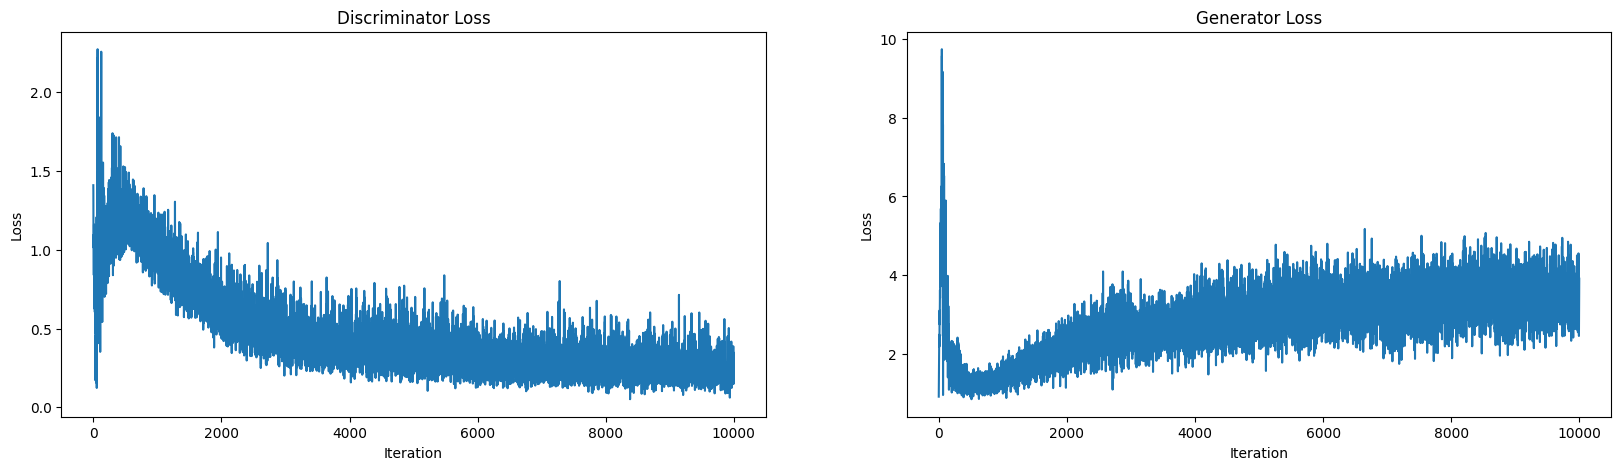

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(d_losses)
ax[0].set_title("Discriminator Loss")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Loss")

ax[1].plot(g_losses)
ax[1].set_title("Generator Loss")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Loss")

In [62]:
fixed_noise = torch.randn((batch_size, z_size)).view(-1, z_size, 1, 1)
if use_gpu:
  fixed_noise = fixed_noise.cuda()

In [63]:
def evaluate_model(g, dataloader, batch_size):
  with torch.no_grad():
    real_img_list = next(iter(dataloader))
    fake_img_list = g(fixed_noise).detach().cpu()
    
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(real_img_list[:batch_size], padding=5), (1, 2, 0)))
    
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(fake_img_list[:batch_size], padding=5), (1, 2, 0)))
    plt.show()

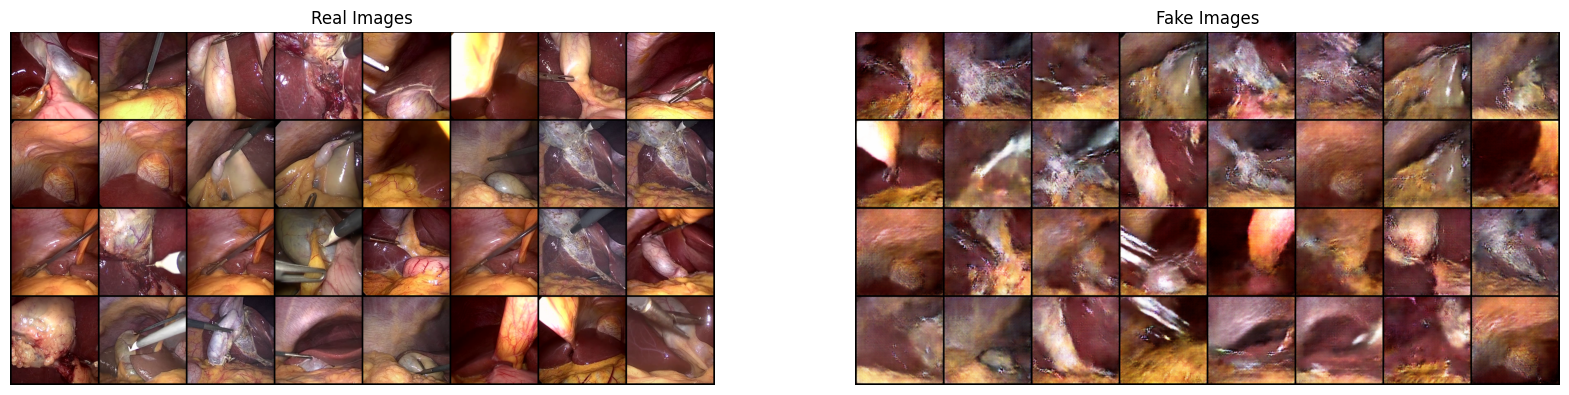

In [64]:
evaluate_model(g, dataloader, batch_size)

In [67]:
torch.save(g, "/content/gdrive/MyDrive/Deep_Learning/saved_models/models/GAN_generator.pt")

In [68]:
torch.save(d, "/content/gdrive/MyDrive/Deep_Learning/saved_models/models/GAN_discriminator.pt")